In [1]:
!git clone https://github.com/abinthomasonline/alexnet-autoencoder.git
!pip install ipython-autotime
%load_ext autotime

Cloning into 'alexnet-autoencoder'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 7), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 24.50 MiB | 25.29 MiB/s, done.
Resolving deltas: 100% (7/7), done.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
time: 366 µs (started: 2024-08-18 23:54:06 +00:00)


In [2]:
# !pip install -r /content/alexnet-autoencoder/requirements.txt

time: 279 µs (started: 2024-08-18 23:54:06 +00:00)


In [3]:
# Create the data directory if it doesn't already exist
!mkdir -p data

# Download the file with wget
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz -P data/

# Extract the contents of the .tgz file
!tar -xzf data/imagenette2.tgz -C data/

--2024-08-18 23:54:06--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.219.224, 16.182.66.232, 52.217.73.110, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.219.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘data/imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  33.3MB/s    in 40s     

2024-08-18 23:54:46 (37.5 MB/s) - ‘data/imagenette2.tgz’ saved [1557161267/1557161267]

time: 58.5 s (started: 2024-08-18 23:54:06 +00:00)


In [4]:
# # """Autoencoder model for image compression using AlexNet as encoder"""
# from torchvision.models import alexnet
# from torchvision.models.alexnet import AlexNet_Weights
# import torch.nn as nn


# class Autoencoder1(nn.Module):
#     def __init__(self):
#         super(Autoencoder1, self).__init__()
#         self.encoder = alexnet(weights=AlexNet_Weights.DEFAULT).features

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2),  # upsample
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(256, 384, kernel_size=3, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(384, 192, kernel_size=3, padding=1),
#             nn.BatchNorm2d(192),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(192, 192, kernel_size=3, stride=2),  # upsample
#             nn.BatchNorm2d(192),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(192, 64, kernel_size=5, padding=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2),  # upsample
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(64, 3, kernel_size=11, stride=4, padding=2, output_padding=1),  # upsample
#             nn.BatchNorm2d(3),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(3, 3, kernel_size=3, padding=1),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# model1 = Autoencoder1()
# save_path = "alexnet_weights.pth"
# torch.save(model1.state_dict(), save_path)

# # Access weights
# # for name, param in model1.named_parameters():
# #     print(f"Layer {name} has weights of shape {param.size()}")

time: 247 µs (started: 2024-08-18 23:55:04 +00:00)


In [5]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import models

time: 8.47 s (started: 2024-08-18 23:55:04 +00:00)


In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: Reduce dimension
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=0),  # Output: [64, 54, 54]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 192, kernel_size=5, padding=4),
            nn.ReLU(True),
        )
        # Decoder: Expand dimension back to original
        self.decoder = nn.Sequential(
            nn.Conv2d(192, 64, kernel_size=5, padding=4),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, kernel_size=3),  # upsample
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=11, stride=4, padding=4, output_padding=1),  # upsample
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),

            nn.Conv2d(3, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


# Initialize the model
model = Autoencoder().to(device)

# Load weights directly to the same device where the model is
weights_path = '/content/Alexnet_weights.pth'
loaded_weights = torch.load(weights_path, map_location=device)

# Manually load the weights into the new models layers
model.encoder[0].weight.data = loaded_weights['encoder.0.weight']
model.encoder[0].bias.data = loaded_weights['encoder.0.bias']

# # Set requires_grad to False to freeze the first layer weights
model.encoder[0].weight.requires_grad = False
model.encoder[0].bias.requires_grad = False

print(np.shape(loaded_weights['encoder.0.weight']))
print(np.shape(loaded_weights['encoder.0.bias']))
print('---------------------------')
# Access weights
for name, param in model.named_parameters():
    print(f"Layer {name} has weights of shape {param.size()}")




print('---------------------------')
# Create a dummy input tensor and move it to the same device as the model
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Perform a forward pass through the model
output = model(dummy_input)
print("Output shape:", output.shape)



# ConvTrans # Hout = stride× (Hin−1) + kernel_size − 2×padding + output_padding
# Conv2d # Hout = [ [ Hin + 2×padding - kernel_size ] / stride ] + 1
# Conv2d is used primarily for downsampling or reducing the spatial dimensions of the input.
# ConvTranspose2d is mainly used for upsampling or increasing the spatial dimensions of the input.

torch.Size([64, 3, 11, 11])
torch.Size([64])
---------------------------
Layer encoder.0.weight has weights of shape torch.Size([64, 3, 11, 11])
Layer encoder.0.bias has weights of shape torch.Size([64])
Layer encoder.2.weight has weights of shape torch.Size([64, 192, 5, 5])
Layer encoder.2.bias has weights of shape torch.Size([192])
Layer decoder.0.weight has weights of shape torch.Size([64, 192, 5, 5])
Layer decoder.0.bias has weights of shape torch.Size([64])
Layer decoder.1.weight has weights of shape torch.Size([64])
Layer decoder.1.bias has weights of shape torch.Size([64])
Layer decoder.3.weight has weights of shape torch.Size([64, 64, 3, 3])
Layer decoder.3.bias has weights of shape torch.Size([64])
Layer decoder.4.weight has weights of shape torch.Size([64])
Layer decoder.4.bias has weights of shape torch.Size([64])
Layer decoder.6.weight has weights of shape torch.Size([64, 3, 11, 11])
Layer decoder.6.bias has weights of shape torch.Size([3])
Layer decoder.7.weight has weight

In [8]:
from torchsummary import summary

# Total params: 5,901,021 for all layers
# Total params: 523,779 for few layers
# Total params: 698,461 for few layers (New version)
# Calculate each layer parameters : Chnnel(output) * [ Chnnel(input) * kernel^2 + 1]

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 54, 54]          23,296
              ReLU-2           [-1, 64, 54, 54]               0
   ConvTranspose2d-3          [-1, 192, 50, 50]         307,392
              ReLU-4          [-1, 192, 50, 50]               0
            Conv2d-5           [-1, 64, 54, 54]         307,264
       BatchNorm2d-6           [-1, 64, 54, 54]             128
              ReLU-7           [-1, 64, 54, 54]               0
   ConvTranspose2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
  ConvTranspose2d-11          [-1, 3, 224, 224]          23,235
      BatchNorm2d-12          [-1, 3, 224, 224]               6
             ReLU-13          [-1, 3, 224, 224]               0
           Conv2d-14          [-1, 3, 2

#**نیازی به ترین قسمت زیر نیست چون زمان میبره تا ترین بشه**

In [9]:
"""Train the autoencoder model on the Imagenette dataset"""

import json
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms


def train(*args, **kwargs):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    # Configs and Hyperparameters
    image_path = "/content/data/imagenette2"
    batch_size = 64
    learning_rate = 1e-4
    # momentum = 0.9
    epochs = 2
    steps_per_epoch = 100
    val_steps = 100
    early_stopping_patience = 10
    checkpoint_dir = "/content/alexnet-autoencoder/checkpoints"
    # os.mkdir(checkpoint_dir)
    checkpoint_interval = 10  # epochs
    best_checkpoint_path = os.path.join(checkpoint_dir, "best.pt")
    latest_checkpoint_path = os.path.join(checkpoint_dir, "latest.pt")

    # Data
    train_path = os.path.join(image_path, "train")
    val_path = os.path.join(image_path, "val")

    train_dataset = datasets.ImageFolder(
        train_path, transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ]))

    val_dataset = datasets.ImageFolder(
        val_path, transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ]))

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    # Model, Loss, Optimizer
    # model = Autoencoder().to(device)#################################################
    loss_fn = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize training variables
    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    metrics = {"epoch": [], "train": [], "eval": []}
    epoch = -1
    best_val_loss = np.inf
    early_stopping_counter = 0

    # Load from checkpoint if exists
    if os.path.exists(latest_checkpoint_path):
        checkpoint = torch.load(latest_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch'] - 1
        early_stopping_counter = checkpoint["early_stopping_counter"]

    # Save zeroth epoch checkpoint for plotting
    if epoch == -1:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict()
        }, os.path.join(checkpoint_dir, f"epoch_{epoch + 1}.pt"))

    # Training loop
    while (epoch + 1) < epochs:
        epoch += 1
        print(epoch)
        # Early stopping
        # if early_stopping_counter == early_stopping_patience:
        #     print("Stopping Criterion Met.. ")
        #     break

        # Train
        model.train()
        train_losses = torch.zeros(steps_per_epoch, device=device)
        for i in range(steps_per_epoch):
            try:
                images, _ = next(train_iter)
                images = images.to(device)
            except StopIteration:
                train_iter = iter(train_loader)
                images, _ = next(train_iter)
                images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            train_losses[i] = loss

        # Eval
        model.eval()
        val_losses = torch.zeros(val_steps, device=device)
        with torch.no_grad():
            for i in range(val_steps):
                try:
                    images, _ = next(val_iter)
                    images = images.to(device)
                except StopIteration:
                    val_iter = iter(val_loader)
                    images, _ = next(val_iter)
                    images = images.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, images)
                val_losses[i] = loss

        metrics["epoch"].append(epoch + 1)
        metrics["train"].append(train_losses.mean().item())
        metrics["eval"].append(val_losses.mean().item())

        # Save best model
        if metrics["eval"][-1] <= best_val_loss:
            best_val_loss = metrics["eval"][-1]
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'loss': best_val_loss,
            }, best_checkpoint_path)
        else:
            early_stopping_counter += 1

        # Save recent checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'loss': metrics["eval"][-1],
            'early_stopping_counter': early_stopping_counter
        }, latest_checkpoint_path)

        # Save checkpoint every n epochs
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'loss': metrics["eval"][-1],
                'early_stopping_counter': early_stopping_counter
            }, os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pt"))

        print("Epoch: {}/{}.. ".format(metrics["epoch"][-1], epochs),
              "Training Loss: {:.3f}.. ".format(metrics["train"][-1]),
              "Validation Loss: {:.3f}.. ".format(metrics["eval"][-1]),
              "Early Stopping Counter: {}/{}.. ".format(early_stopping_counter, early_stopping_patience))

    # Save metrics
    with open(os.path.join(checkpoint_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f)


if __name__ == "__main__":
    train()


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0
Epoch: 1/2..  Training Loss: 1.234..  Validation Loss: 1.036..  Early Stopping Counter: 0/10.. 
1
Epoch: 2/2..  Training Loss: 0.924..  Validation Loss: 0.797..  Early Stopping Counter: 0/10.. 
time: 2min 24s (started: 2024-08-18 23:56:20 +00:00)


# **حتما این قسمت باید ترین بشه تا وزن ها آپدیت بشند**

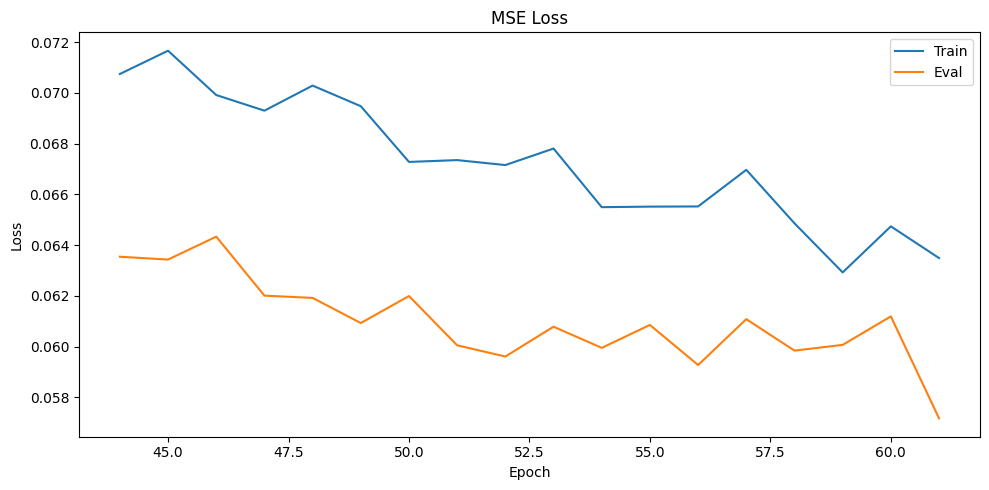

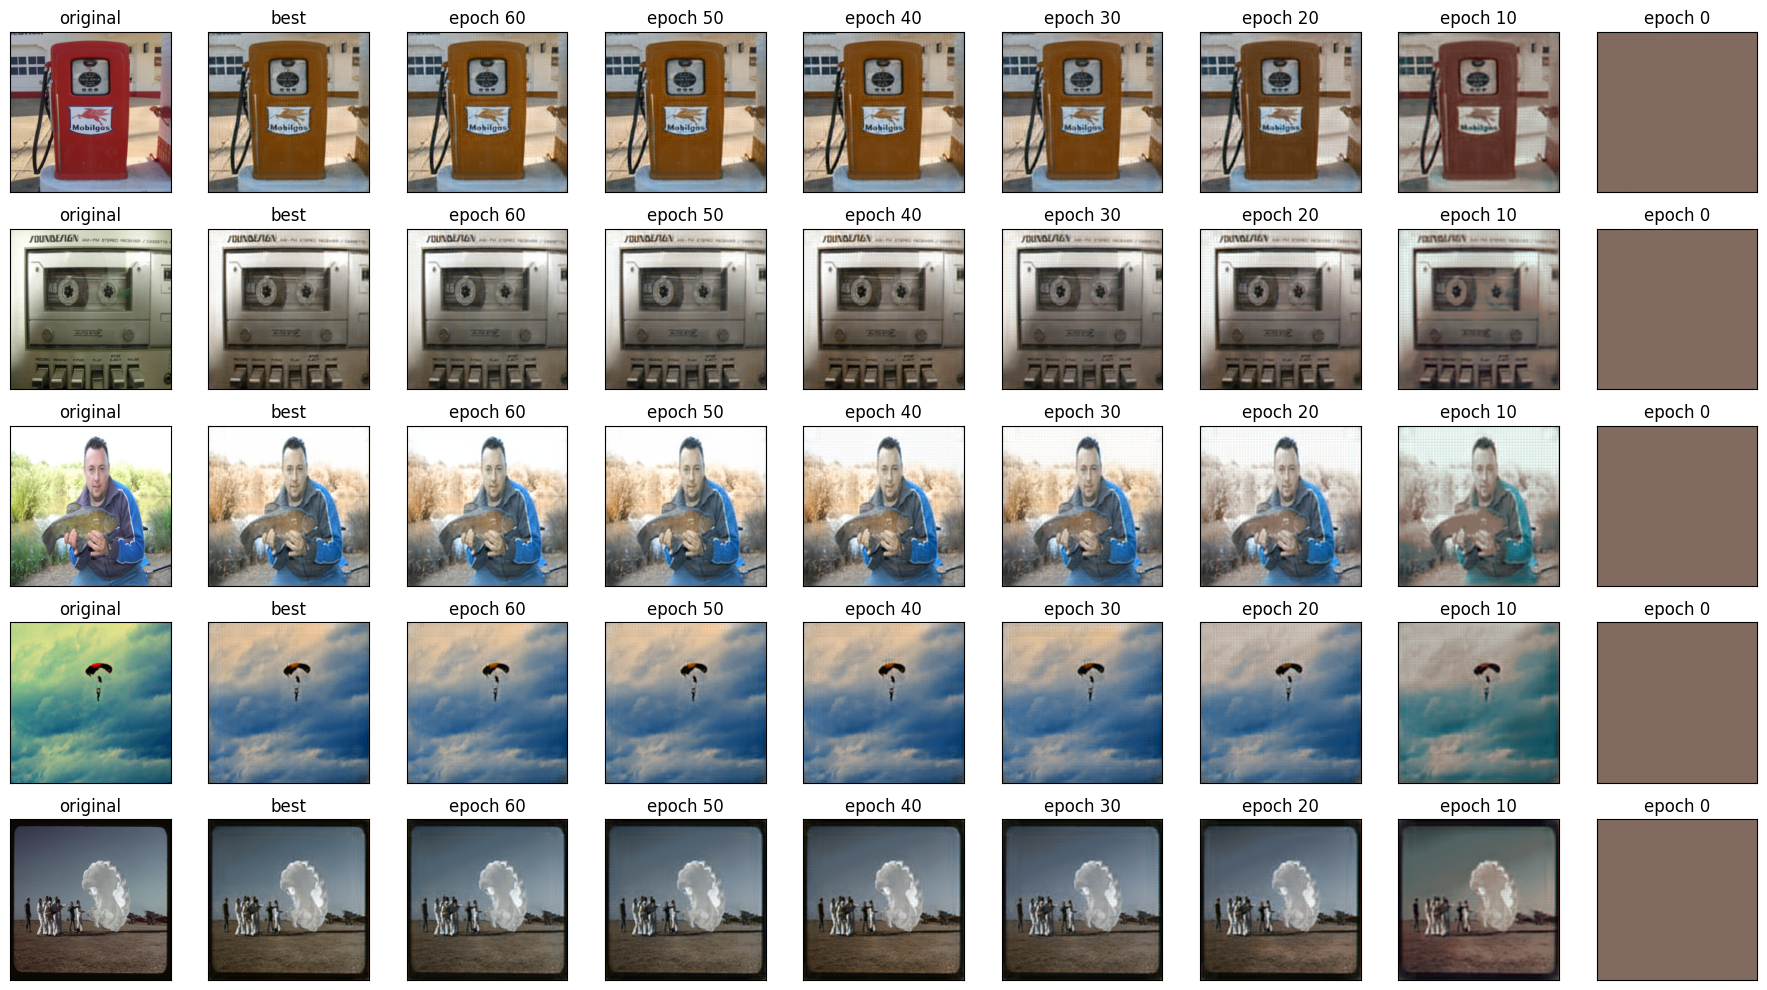

In [10]:
"""Plot metrics and images"""

import json
import os

import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms



def plot(*args, **kwargs):

    # Configs
    checkpoint_dir = "/content/alexnet-autoencoder/checkpoints"
    plots_dir = "plots"
    metrics_path = os.path.join(checkpoint_dir, "metrics.json")
    num_images = 5
    best_checkpoint_path = os.path.join(checkpoint_dir, "best.pt")

    # Load metrics
    with open(metrics_path, "r") as f:
        metrics = json.load(f)

    # Plot metrics
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(metrics["epoch"], metrics["train"], label="Train")
    ax.plot(metrics["epoch"], metrics["eval"], label="Eval")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("MSE Loss")
    ax.legend()
    fig.tight_layout()
    # fig.savefig(os.path.join(plots_dir, "loss.png"))

    # Data
    image_path = "/content/data/imagenette2"
    val_path = os.path.join(image_path, "val")
    val_dataset = datasets.ImageFolder(
        val_path, transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ]))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=num_images, shuffle=True)
    images, _ = next(iter(val_loader))

    # Model
    model = Autoencoder()
    inverse_transform = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

    # Original images
    original_images = torch.clamp(inverse_transform(images), 0, 1)

    # Best checkpoint
    checkpoint = torch.load(best_checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    with torch.no_grad():
        best_reconstructions = model(images)
    best_reconstructions = torch.clamp(inverse_transform(best_reconstructions), 0, 1)

    # checkpoints
    intermediate_reconstructions = []
    epochs = sorted([int(filename.split(".")[0].split("_")[1])
                     for filename in os.listdir(checkpoint_dir)
                     if filename.startswith("epoch_") and filename.endswith(".pt")], reverse=True)
    for epoch in epochs:
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pt")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        with torch.no_grad():
            reconstructions = model(images)
        reconstructions = torch.clamp(inverse_transform(reconstructions), 0, 1)
        intermediate_reconstructions.append(reconstructions)

    # Plot
    n_rows = num_images
    n_cols = len([original_images, best_reconstructions] + intermediate_reconstructions)
    img_size = 2
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*img_size, n_rows*img_size))
    for i in range(n_rows):
        # Original images
        ax[i][0].imshow(torch.permute(original_images[i], (1, 2, 0)))
        ax[i][0].get_xaxis().set_visible(False)
        ax[i][0].get_yaxis().set_visible(False)
        ax[i][0].set_title("original")

        # Best reconstructions
        ax[i][1].imshow(torch.permute(best_reconstructions[i], (1, 2, 0)))
        ax[i][1].get_xaxis().set_visible(False)
        ax[i][1].get_yaxis().set_visible(False)
        ax[i][1].set_title("best")

        # Intermediate reconstructions
        for j, epoch in enumerate(epochs):
            intermediate_reconstruction = intermediate_reconstructions[j]
            ax[i][j + 2].imshow(torch.permute(intermediate_reconstruction[i], (1, 2, 0)))
            ax[i][j + 2].get_xaxis().set_visible(False)
            ax[i][j + 2].get_yaxis().set_visible(False)
            ax[i][j + 2].set_title(f"epoch {epoch}")
    fig.tight_layout()
    # fig.savefig(os.path.join(plots_dir, "reconstructions.png"))


if __name__ == "__main__":
    plot()


time: 6.95 s (started: 2024-08-18 23:59:55 +00:00)


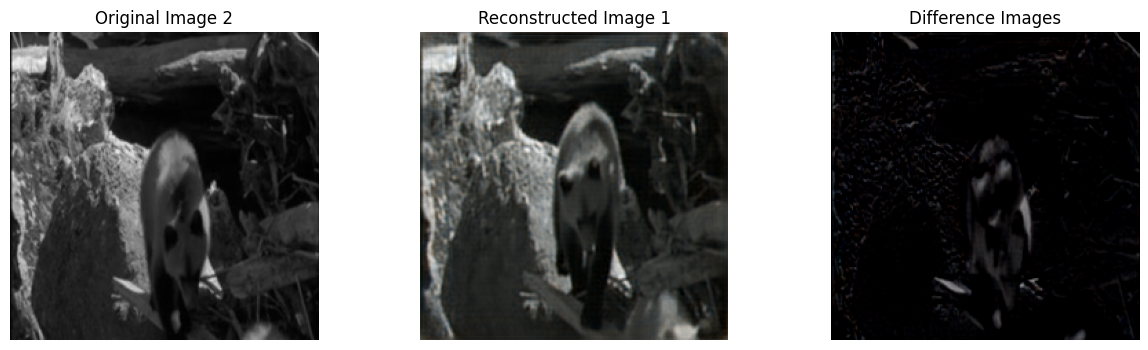

time: 763 ms (started: 2024-08-19 00:00:02 +00:00)


In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Path to the image
img_path = "/content/12(1).jpeg"
img_path_2 = "/content/12(2).jpeg"
# img_path = "/content/008 (1).jpeg"
# img_path_2 = "/content/008 (2).jpeg"

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming this was your training resolution
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and transform the image
img = Image.open(img_path).convert("L")
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

# Load the model and weights
model = Autoencoder()
checkpoint = torch.load("/content/alexnet-autoencoder/checkpoints/best.pt", map_location=torch.device('cpu'))  # Adjust device if using GPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Perform inference
with torch.no_grad():
    reconstruction = model(img_transformed)

# Inverse normalize the output image for display
inverse_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
img_reconstructed = inverse_transform(reconstruction.squeeze(0))  # Remove batch dimension
img_reconstructed = torch.clamp(img_reconstructed, 0, 1)

import numpy as np

# Assuming the inverse normalization definition is correct
# Helper function to undo normalization for display
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)    # The inverse of normalization
    return tensor

# Apply inverse normalization to the transformed original image for visualization
img_transformed_vis = inverse_normalize(img_transformed.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_transformed_vis = img_transformed_vis.permute(1, 2, 0)  # Rearrange dimensions to HxWxC
img_transformed_vis = torch.clamp(img_transformed_vis, 0, 1)  # Ensure the pixel values are valid

# Path to the image
img_path = img_path_2

# Load and transform the image
img = Image.open(img_path).convert("L")
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

# Apply inverse normalization to the transformed original image for visualization
img_transformed_vis = inverse_normalize(img_transformed.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_transformed_vis = img_transformed_vis.permute(1, 2, 0)  # Rearrange dimensions to HxWxC
img_transformed_vis = torch.clamp(img_transformed_vis, 0, 1)  # Ensure the pixel values are valid

# img_reconstructed is already in the correct format (C, H, W) and range [0, 1] after clamping
# img_transformed_vis was intended for visualization and is a numpy array in (H, W, C) format

# Convert img_transformed_vis back to a PyTorch tensor and ensure it's in (C, H, W) format for subtraction
img_transformed_vis_tensor = torch.from_numpy(img_transformed_vis.numpy()).permute(2, 0, 1)

# Both tensors should now be in the (C, H, W) format; ensure they're on the same device
img_transformed_vis_tensor = img_transformed_vis_tensor.to("cpu")  # Adjust this as necessary
img_reconstructed = img_reconstructed.to("cpu")  # Ensure this matches your device context

# Perform the subtraction. Now that dimensions and devices match, this should work without error
image_diff = img_transformed_vis_tensor - img_reconstructed

# Clamp the result to ensure it's within a valid range for visualization
image_diff_clamped = torch.clamp(image_diff, 0, 1)

# For visualization, convert back to (H, W, C) format
image_diff_np = image_diff_clamped.permute(1, 2, 0).numpy()

# Plotting the difference image
# Plotting
plt.figure(figsize=(15, 4))

# Display the original image (after undoing the transformations for visualization purposes)
plt.subplot(1, 3, 1)
plt.imshow(img_transformed_vis.numpy())
plt.title("Original Image 2")
plt.axis('off')

# Display the reconstructed image (already correctly handled)
plt.subplot(1, 3, 2)
# No need for additional permute or .cpu() as it's already handled correctly
plt.imshow(img_reconstructed.permute(1, 2, 0).numpy())
plt.title("Reconstructed Image 1")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_diff_np)
plt.title("Difference Images")
plt.axis('off')
plt.show()


# **خروجی لایه اول**

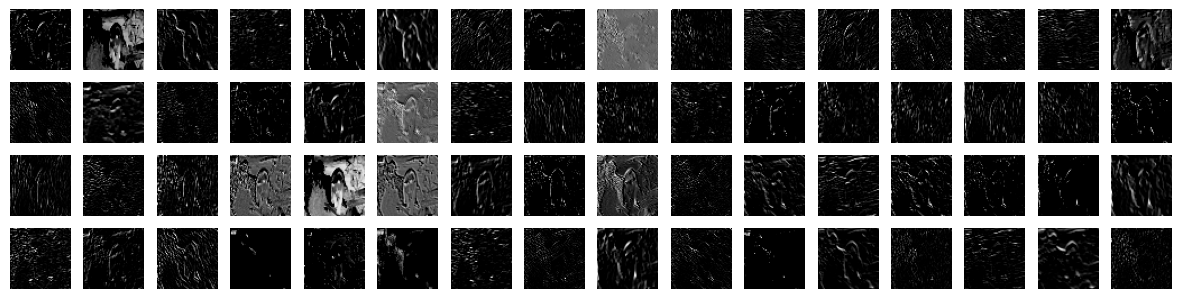

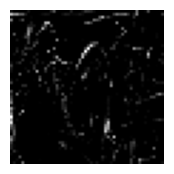

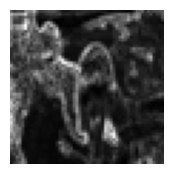

time: 2.08 s (started: 2024-08-19 00:00:03 +00:00)


In [12]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and transform the image
img_path = "/content/12(1).jpeg"
# img_path = "/content/008 (1).jpeg"
img = Image.open(img_path).convert("L")  # Convert to RGB to match training data format
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

# Load the model and weights
model = Autoencoder()
checkpoint = torch.load("/content/alexnet-autoencoder/checkpoints/best.pt", map_location=torch.device('cpu'))  # Adjust device if using GPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Hook to capture the output of the first layer
first_layer_output = []

def hook_fn(module, input, output):
    first_layer_output.append(output)

# Register the hook
first_layer = model.encoder[0]  # Adjust based on the first layer in your model
hook = first_layer.register_forward_hook(hook_fn)

# Perform inference
with torch.no_grad():
    _ = model(img_transformed)

# Remove the hook
hook.remove()

# Extract the output of the first layer
first_layer_output = first_layer_output[0]

# Normalize the output for visualization
first_layer_output = first_layer_output.squeeze(0)  # Remove batch dimension
first_layer_output = first_layer_output.permute(1, 2, 0)  # Rearrange dimensions to HxWxC

# Plot the output of the first layer
plt.figure(figsize=(15, 15))
num_filters = first_layer_output.shape[2]
for i in range(num_filters):
    plt.subplot(16, 16, i + 1)  # Assuming 256 filters for 16x16 grid
    plt.imshow(first_layer_output[:, :, i].cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()


# Plot the output of the first layer
plt.figure(figsize=(2, 2))
num_filters = first_layer_output.shape[2]
for i in range(1):
    plt.subplot(1, 1, i + 1)  # Assuming 256 filters for 16x16 grid
    plt.imshow(first_layer_output[:, :, i].cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()

mean_output = np.mean(first_layer_output.cpu().numpy(), axis=2)
# Plot the output of the first layer
plt.figure(figsize=(2, 2))
num_filters = first_layer_output.shape[2]
for i in range(1):
    plt.subplot(1, 1, i + 1)  # Assuming 256 filters for 16x16 grid
    plt.imshow(mean_output, cmap='gray')
    plt.axis('off')

plt.show()


# **Images Correlation images**


In [16]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


# Resize function
def resize_image(image, size=(255, 255)):
    return cv2.resize(image, size)

# Correlation calculation function
def calculate_correlation(image1, image2):
    # Ensure the images are resized
    image1_resized = resize_image(image1)
    image2_resized = resize_image(image2)

    # Flatten the images
    vector1 = image1_resized.flatten()
    vector2 = image2_resized.flatten()

    # Calculate Pearson correlation coefficient
    correlation = np.corrcoef(vector1, vector2)[0, 1]
    return correlation

correlation = []

!unzip '/content/animals.zip'
!unzip '/content/nonanimals.zip'


for j in range(1,7):

  for i in range(1, 103):

    print(j, '---', i)

    if j < 4:
      if i < 10:
        img_path = f'/content/animals/{i}/00{i} ({j}).jpeg'
      elif i < 100:
        img_path = f'/content/animals/{i}/0{i} ({j}).jpeg'
      else:
        img_path = f'/content/animals/{i}/{i} ({j}).jpeg'
    else:
      if i < 10:
        img_path = f'/content/nonanimals/{i}/00{i} ({j-3}).jpeg'
      elif i < 100:
        img_path = f'/content/nonanimals/{i}/0{i} ({j-3}).jpeg'
      else:
        img_path = f'/content/nonanimals/{i}/{i} ({j-3}).jpeg'


    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Assuming this was your training resolution
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and transform the image
    img = Image.open(img_path).convert("L")
    img_transformed = transform(img)
    img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

    # Load the model and weights
    model = Autoencoder()
    checkpoint = torch.load("/content/alexnet-autoencoder/checkpoints/best.pt", map_location=torch.device('cpu'))  # Adjust device if using GPU
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Perform inference
    with torch.no_grad():
        reconstruction = model(img_transformed)

    # Inverse normalize the output image for display
    inverse_transform = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_reconstructed = inverse_transform(reconstruction.squeeze(0))  # Remove batch dimension
    img_reconstructed = torch.clamp(img_reconstructed, 0, 1)

    import numpy as np

    # Assuming the inverse normalization definition is correct
    # Helper function to undo normalization for display
    def inverse_normalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)    # The inverse of normalization
        return tensor

    # Apply inverse normalization to the transformed original image for visualization
    img_transformed_vis = inverse_normalize(img_transformed.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_transformed_vis = img_transformed_vis.permute(1, 2, 0)  # Rearrange dimensions to HxWxC
    img_transformed_vis = torch.clamp(img_transformed_vis, 0, 1)  # Ensure the pixel values are valid


    # Load and transform the image
    img = Image.open(img_path).convert("L")
    img_transformed = transform(img)
    img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension

    # Apply inverse normalization to the transformed original image for visualization
    img_transformed_vis = inverse_normalize(img_transformed.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_transformed_vis = img_transformed_vis.permute(1, 2, 0)  # Rearrange dimensions to HxWxC
    img_transformed_vis = torch.clamp(img_transformed_vis, 0, 1)  # Ensure the pixel values are valid

    # img_reconstructed is already in the correct format (C, H, W) and range [0, 1] after clamping
    # img_transformed_vis was intended for visualization and is a numpy array in (H, W, C) format

    # Convert img_transformed_vis back to a PyTorch tensor and ensure it's in (C, H, W) format for subtraction
    img_transformed_vis_tensor = torch.from_numpy(img_transformed_vis.numpy()).permute(2, 0, 1)

    # Both tensors should now be in the (C, H, W) format; ensure they're on the same device
    img_transformed_vis_tensor = img_transformed_vis_tensor.to("cpu")  # Adjust this as necessary
    img_reconstructed = img_reconstructed.to("cpu")  # Ensure this matches your device context





    # Convert reconstructed image to uint8 for compatibility with OpenCV
    reconstructed_image1_uint8 = cv2.normalize(img_reconstructed.permute(1, 2, 0).numpy()[:, :, 0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Read the second image using OpenCV
    image2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Calculate the correlation
    correlation.append(calculate_correlation(reconstructed_image1_uint8, image2))



print(f'Mean Correlation between the two images: {np.mean(correlation)}')
print(f'Std Correlation between the two images: {np.std(correlation)}')

Archive:  /content/animals.zip
   creating: animals/1/
  inflating: animals/1/001 (1).jpeg  
  inflating: animals/1/001 (2).jpeg  
  inflating: animals/1/001 (3).jpeg  
   creating: animals/10/
  inflating: animals/10/010 (1).jpeg  
  inflating: animals/10/010 (2).jpeg  
  inflating: animals/10/010 (3).jpeg  
   creating: animals/100/
  inflating: animals/100/100 (1).jpeg  
  inflating: animals/100/100 (2).jpeg  
  inflating: animals/100/100 (3).jpeg  
   creating: animals/101/
  inflating: animals/101/101 (1).jpeg  
  inflating: animals/101/101 (2).jpeg  
  inflating: animals/101/101 (3).jpeg  
   creating: animals/102/
  inflating: animals/102/102 (1).jpeg  
  inflating: animals/102/102 (2).jpeg  
  inflating: animals/102/102 (3).jpeg  
   creating: animals/11/
  inflating: animals/11/011 (1).jpeg  
  inflating: animals/11/011 (2).jpeg  
  inflating: animals/11/011 (3).jpeg  
   creating: animals/12/
  inflating: animals/12/012 (1).jpeg  
  inflating: animals/12/012 (2).jpeg  
  infl